## 0 to 280: Getting Twitter timeline data for your awesome NLP project

### Part 2: Analyzing Donald Trump's Tweets

###### By Eleanor Stribling, October 2018


If you enjoy Natural Language Processing like I do, you might have some ideas for analyses you could do using Twitter. What are the word patterns and hashtags that the tweeter uses?  How do these change over time?  What sites do they link to?  What words appear around others?  Who or what do they talk about?

In [part 1](https://medium.com/agatha-codes/0-to-280-getting-twitter-timeline-data-for-your-awesome-nlp-project-ff41b941ed6), I used [NASA's Twitter feed](https://twitter.com/NASA) as an example, and was originally planning to do the same in Part 2.  However, this time I'm going to do perhaps the most obvious analysis: using [Donald Trump's tweets](https://twitter.com/realdonaldtrump).  

#### 📣PSA 📣
```I am 100% opposed to Trump/GOP/bigots, but I approached this analysis the same way I would approach any project, and all of the code is publicly available so you can evaluate its soundness for yourself.  Quantifying what he says was honestly a little depressing, but I hope that an example that is extreme and in the public consciousness in the United States and beyond will demonstrate the power of these techniques and how a straightforward analysis of his tweets betrays his worst characteristics.```

```If you're upset because I'm looking at something political this time, I code mostly because I believe in the power of technology to change the world for the better, and calling out bad actors with data is one way, in my opinion, to do that.  If you don't like the politics, you are in the wrong place.```


If you missed part 1, you can view it on [Github](https://github.com/eleanorstrib/twitter_timeline_analysis_1) and the accompanying [post](https://medium.com/agatha-codes/0-to-280-getting-twitter-timeline-data-for-your-awesome-nlp-project-ff41b941ed6) on my blog, [agatha.codes](https://medium.com/agatha-codes).

Here's a summary of what we've completed in part 1 (✅) and what we will cover in this post (📋)  :

A. Obtain and clean the data from a Twitter user's timeline ✅

B. Export into a csv file and a Python dictionary ✅

C. Apply analysis tools from NLTK to get summary data and explore hypotheses about the user's tweets 📋

D. Use Python libraries to visualize the data you collect 📋

This tutorial can be found on [Github](https://github.com/eleanorstrib/twitter_timeline_analysis_2) and [agatha.codes](https://medium.com/p/5a2d387ce37d/edit).  Hope you find it useful for your own projects, and please let me know via the comments section on the blog post of any feedback or questions.

### Running the steps from part 1 ✅
In the cells below, I'm re-running some of the steps from the previous tutorial.  Differences from part 1 are marked with a 🆕.

In [1]:
# import libraries
import csv
from datetime import datetime
import os
import re
import requests
import twitter
import lxml.html

In [2]:
# set variables for keys and tokens to access the Twitter API
TWITTER_CONS_KEY = os.environ.get('T_CONS_')
TWITTER_CONS_SEC = os.environ.get('T_CONS_SECRET')
TWITTER_ACCESS_TOKEN = os.environ.get('T_ACCESS_')
TWITTER_ACCESS_SEC = os.environ.get('T_ACCESS_SECRET')

In [3]:
# create an object for querying the API using the python-twitter library
t = twitter.Api(
    consumer_key = TWITTER_CONS_KEY,
    consumer_secret = TWITTER_CONS_SEC,
    access_token_key = TWITTER_ACCESS_TOKEN, 
    access_token_secret = TWITTER_ACCESS_SEC,
    tweet_mode='extended' # this ensures that we get the full text of the users' original tweets
)

In [4]:
# 🆕name of the account you want to analyze
screen_name = "realdonaldtrump"

In [5]:
# call the Twitter API, get 200 tweets
first_200 = t.GetUserTimeline(screen_name=screen_name, count=200)

In [6]:
# function to get more tweets up to the rate limit
def get_tweets(first_200, screen_name, last_id):
    all_tweets = []
    all_tweets.extend(first_200)
    for i in range(900):
        new = t.GetUserTimeline(screen_name=screen_name, max_id=last_id-1)
        if len(new) > 0:
            all_tweets.extend(new)
            last_id = new[-1].id
        else:
            break
    
    return all_tweets

In [7]:
# call the function
all_tweets = get_tweets(first_200, screen_name, first_200[-1].id)

In [8]:
# now we have a variable, all_tweets with a big, reverse chronological list of tweet objects with these attributes
print([a for a in dir(all_tweets[0]) if '_' not in a and a[0].islower()])

['contributors', 'coordinates', 'favorited', 'geo', 'hashtags', 'id', 'lang', 'location', 'media', 'place', 'retweeted', 'scopes', 'source', 'text', 'truncated', 'urls', 'user']


In [9]:
# write out cleaning funtions
def clean_hashtags(hashtags):
    """
    Turns data with any number of hashtags like this - [Hashtag(Text='STEMonStation')] - to a list like this -
    ['STEMonStation']
    """
    cleaned = []
    if len(hashtags) >= 1:
        for i in range(len(hashtags)):
            cleaned.append(hashtags[i].text)        
    return cleaned

def clean_urls(urls):
    """
    Turns data with any number of expanded urls like this - 
    [URL(URL=https://t.co/sYCFHKxzBf, ExpandedURL=https://youtu.be/34bFgA3H3hQ)]- to a list like this - 
    ["https://youtu.be/34bFgA3H3hQ"]
    """
    cleaned = []
    if len(urls) >= 1:
        for i in range(len(urls)):
            cleaned.append(urls[i].expanded_url)
    return(cleaned)
        

def clean_source(source):
    """
    Turns data including the source and some html like this - 
    <a href="https://www.sprinklr.com" rel="nofollow">Sprinklr</a> - to a list like this -
    ['Sprinklr']
    """
    raw = lxml.html.document_fromstring(source)
    return raw.cssselect('body')[0].text_content()


def string_to_datetime(date_str):
    """
    Turns a string including date and time like this - Sun Jul 01 21:06:07 +0000 2018 - to a Python datetime object
    like this - datetime.datetime(2018, 7, 1, 21, 6, 7, tzinfo=datetime.timezone.utc)
    """
    return datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')


In [10]:
# make a function to create a dict
def create_dict(tweets):
    dict = {}
    for item in tweets:
        clean_source(item.source)
        dict[item.id_str] = {
            'full_text': item.full_text,
            'hashtags': clean_hashtags(item.hashtags),
            'urls': clean_urls(item.urls),
            'created_at': string_to_datetime(item.created_at),
            'favorite_count': item.favorite_count,
            'retweet_count' : item.retweet_count,
            'source': clean_source(item.source)
        }
    return dict

In [11]:
# call the function and create our dictionary
tweet_dict = create_dict(all_tweets)

In [12]:
# check the data
if len(all_tweets) == len(tweet_dict):
    print("We have all of the tweets in the dictionary that we collected from the API!  {} total. ☺️".format(len(tweet_dict)))
else:
    print("Something went wrong - check the create_dict function to ensure no tweets were missed. 😬")

We have all of the tweets in the dictionary that we collected from the API!  3225 total. ☺️


That's what we covered in the last tutorial.  Now let's get to the analysis!

That said, the basic analysis below will help you to explore the data and choose a hypothesis to dig into.  That I will demonstrate below.

### Let's get started with the new material. 📋

## Step 0: Identify hypotheses 🤔

With any analysis, I expect to do some discovery work when I start looking at the data, but there are a couple of things I wanted to look at for this specfic Twitter account - mostly the senses I had about 

- I think he uses the words "great", "fake news" and "no collusion" a lot.
- He still fires off the occasional "crooked Hillary" tweet, more than a year after the election.
- Terms associated with female political opponents focus on their looks, with the strongest insults aimed at Black women.
- Most of the tweets will come from an iPhone, with the less insulting ones coming almost exclusively from other sources.

While we'll do some general analysis, I'm going to attempt to figure out if these hypotheses are correct or not.  

## Step 1: Get some summary stats on the data set 📊

Getting a high level understanding of what's in the data set is usually my first step. Let's start by getting a high level quantitative view of what we have before we dive into the text.

First, let's import some libraries we'll need for this tutorial.  There's a mix of quantitative tools for this step and NLTK features for looking at the text in step 2.

Note that this introduces some new stuff you'll need to install in your virtual environment.  You can add these one by one or run `pip intall -r requirements.txt` - the `requirements.txt` file in this repo has been updated from the last tutorial.

In [13]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from nltk import bigrams, trigrams, Text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from prettytable import PrettyTable
from scipy import stats
from string import punctuation as punc
from urllib.parse import urlparse

Let's remind ourselves of what each entry looks like.  Remember that `tweet_dict` is a dictionary where we are storing all of our data, the keys are strings with the ID number of the tweet, and the value (printed below) is another dictionary with the specifics on that tweet.

In [23]:
# here is a pretty recent tweet when this workbook was written
print(tweet_dict['1052213711295930368'])

{'full_text': 'RT @USMC: LIVE from the White House: Sgt. Maj. John Canley becomes the 300th Marine to receive the Medal of Honor. https://t.co/sD93rrqaoZ', 'hashtags': [], 'urls': ['https://www.pscp.tv/w/bpeOYTFEWktva1lXUllLYXl8MVBsS1FyYk1sb01HRXPHd1rZCqDMO_FR6f_yZ8gMOPOXaKPR47l6J5DOvisi'], 'created_at': datetime.datetime(2018, 10, 17, 20, 11, 53, tzinfo=datetime.timezone.utc), 'favorite_count': 0, 'retweet_count': 11133, 'source': 'Twitter for iPhone'}


We have a few fields here we can quantify to get a broad idea of what the characteristics of the data set are:
- High level picture of the data set (`num_and_date` function)
   - Number of tweets
   - Dates of most recent and oldest tweets
- Summary stats on the numeric fields (`metric_summary` function)
   - Likes
   - Retweets
- Summary stats on the strings that are not directly contained in the tweet (`enum_analysis_pie` function)
   - Sources
   - URLs

The reason I'm not looking at the content of the tweets yet, is I want to use some NLTK tools on those, and they require a bit more cleaning before we can do much there.

Let's write some code to get us that information in the `tweet_summary` function!

In [16]:
def num_and_date(name, all_tweets, tweet_dict):
    # first, let's get the total number of tweets
    total_tweets = len(tweet_dict)
    
    # now the date range - these are formatted as datetime objects so I can subtract one from the other
    oldest_tweet_id, newest_tweet_id = str(all_tweets[-1].id), str(all_tweets[0].id)
    oldest_tweet_date, newest_tweet_date = tweet_dict[oldest_tweet_id]['created_at'], tweet_dict[newest_tweet_id]['created_at']
    date_range = (newest_tweet_date-oldest_tweet_date).days
    
    # print the results
    print("Here's a high level summary for our dataset for {}:".format(name))
    print()
    print("There are {} tweets total.".format(total_tweets))
    print()
    print("These tweets were posted in the {} days between {}/{}/{} and {}/{}/{}.".format(date_range,
                                                                              oldest_tweet_date.month,
                                                                              oldest_tweet_date.day,
                                                                              oldest_tweet_date.year, 
                                                                              newest_tweet_date.month,
                                                                              newest_tweet_date.day,
                                                                              newest_tweet_date.year,))
    

In [17]:
num_and_date(screen_name, all_tweets, tweet_dict)

Here's a high level summary for our dataset for realdonaldtrump:

There are 3225 tweets total.

These tweets were posted in the 361 days between 10/25/2017 and 10/21/2018.


Now that we've done that, the `metric_summary` function below will do some calculations for us on favorites and retweets.

In [18]:
# first, we will pull the data we need out of the tweet_dict variable, and create big lists of every
# date, favorite and rt; we'll use all_tweets because that's an ordered list and the values will align in our lists
# while dictionaries are ordered in python 3*, doing it this way just in case you're using an older version ☺️
dates = [string_to_datetime(t.created_at) for t in all_tweets]
f_arr = [t.favorite_count for t in all_tweets]
r_arr = [t.retweet_count for t in all_tweets]


In [24]:
def metric_summary(name, metric, arr, color, dates, td):
    # first we're going to pull some summary stats for the account using the "describe" function from SciPy
    data_sum = stats.describe(arr)
    avg = int(data_sum.mean)
    most = data_sum.minmax[1]
    least = data_sum.minmax[0]
    # here we're searching for the tweet with the biggest quantity of the metric we're looking at by getting the id
    # and searching tweet_dict
    top = [k for k, v in td.items() if v[metric+'_count'] == most]
    bottom = top = [k for k, v in td.items() if v[metric+'_count'] == least]
    
    # print out the results
    print("Let's look at {}s for the {} dataset".format(metric, name))
    print("The average {} tweet got {} {}s.".format(name, avg, metric))
    print("The lowest number of {}s a tweet got was {}.".format(metric, least))
    if len(top) >= 1:
        top_tweet_id = top[0]
        url = "https://twitter.com/{}/status/{}".format(name, top_tweet_id)
        print("The most {}ed tweet in the dataset got {} favorites.  Here's the link: {}".format(metric,most,url) )
    
    # plot the timeseries distribution to look for trends and get a visual
    plt.plot_date(x=dates, y=arr, fmt="r-", color=color)
    plt.title("Timeseries plot of {}s for {}".format(metric, name))
    plt.ylabel(metric+"s")
    plt.grid(True)
    plt.show()


Let's look at favorites for the realdonaldtrump dataset
The average realdonaldtrump tweet got 75467 favorites.
The lowest number of favorites a tweet got was 0.
The most favoriteed tweet in the dataset got 594127 favorites.  Here's the link: https://twitter.com/realdonaldtrump/status/1052653446053154816


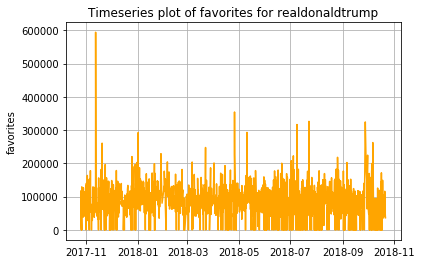

Let's look at retweets for the realdonaldtrump dataset
The average realdonaldtrump tweet got 19345 retweets.
The lowest number of retweets a tweet got was 1093.
The most retweeted tweet in the dataset got 253729 favorites.  Here's the link: https://twitter.com/realdonaldtrump/status/971345895223676929


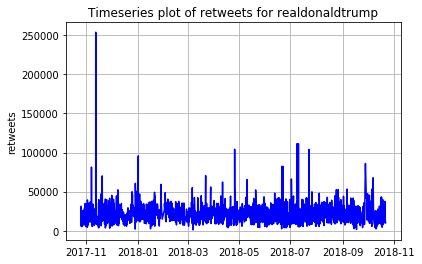

In [25]:
# now we call metric_summary twice, once for favorites, and once for retweets
metric_summary(screen_name, "favorite", f_arr, "orange", dates, tweet_dict)
metric_summary(screen_name, "retweet", r_arr, "blue", dates, tweet_dict)

### Example 🔍

You might be running this workbook on data other than the Trump Twitter account, but there were a lot of variables flying around in the functions above, so let's pause and show an example of what you should be seeing (more or less) and things you can draw from this data.

The example below is an analysis of the realdonaldtrump account data set at the time of this workbook's writing, in October 2018.

<img src="img/fav_rt_analysis.png"/>

From this analysis, I can see that the most favorited and retweeted tweet has the same url, and it was an insult directed at another head of state.

<img src="img/rdt_mostpopular.png" align="left" height="300"/>

You can see from the charts and by the averages that this tweet was a serious outlier.  There are so many extreme and embarassing tweets in this collection, I'm not sure why that one got so much attention.

So we've covered the high level stats for the data set and some quantitative measures for numerical fields, favorites and retweets, so the last part of this step is examining the source and url fields.

Recall that we cleaned these two fields above and in the last tutorial to contain lists of sources and expanded urls.  These aren't quite enumerated fields, but they are likely close enough that we can take a quantitative approach to them.

First, let's make lists of these as we did with favorites and retweets.

In [26]:
# sources
s_arr = [v['source'] for k, v in tweet_dict.items()]
print("The sources list looks like this: ", s_arr[0:5])
print()

The sources list looks like this:  ['Twitter for iPhone', 'Twitter for iPhone', 'Twitter for iPhone', 'Twitter for iPhone', 'Twitter for iPhone']



In [27]:
#urls
u_arr = [v['urls'] for k, v in tweet_dict.items()]
print("The urls list looks like this: ", u_arr[0:5])
print()
# for urls, we need another step, because unlike every other field we've used so far, there can be
# more than one value in a list of values, and it's likely that each one is a link to a different page

# to summarize these, we're going to use another list comprehension to flatten the list and use the urlparse method to 
# retain only the domain of the link (e.g. https://go.nasa.gov/2KF6Cnu and https://go.nasa.gov/7fh90y
# should both count as go.nasa.gov)
u_arr_flat = [urlparse(item).netloc for s in u_arr for item in s]

# print the results to see what the data looks like now
print("The cleaned url list looks like this: ", u_arr_flat[0:5])

The urls list looks like this:  [[], [], [], [], []]

The cleaned url list looks like this:  ['Vote.GOP', 'Vote.GOP', 'www.facebook.com', 'Vote.GOP', 'Vote.GOP']


In [30]:
def enum_analysis_pie(name, metric, arr, top_num):
    
    # we use a Counter object to summarize our lists of values
    counts = Counter(arr).most_common(top_num) # the function will take the most popular n values for the charts
    
    # counts is a list of tuples (e.g. ('Source', #))
    labels = [c[0] for c in counts]
    sizes = [c[1] for c in counts]
    
    # now let's plot it!
    fig1, ax1 = plt.subplots(figsize=(7,7), subplot_kw=dict(aspect="equal"))
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=50)
    ax1.axis('equal')  # equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Top {} {}s for {}'s tweets:".format(top_num, metric, name))
    plt.show()

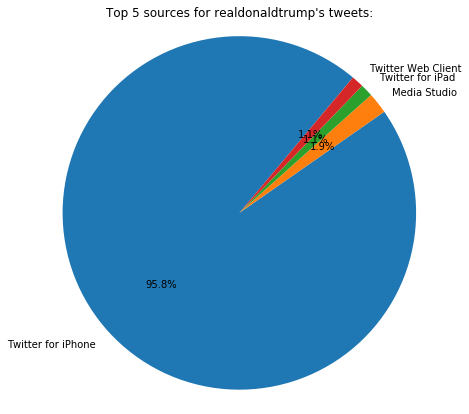

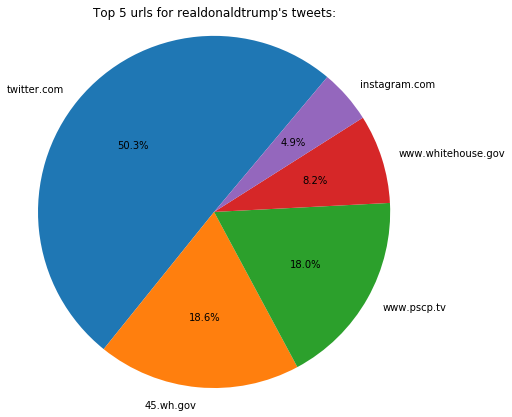

In [31]:
# call the function to display the pie charts for the distribution of the top 5 results for each data type
enum_analysis_pie(screen_name, 'source', s_arr, 5)
enum_analysis_pie(screen_name, 'url', u_arr_flat, 5)

For the NASA Twitter feed at the time of this writing (July 2018) here are the results I got and some analysis:

For the sources, most of the NASA tweets are coming from Sprinklr, a social media management platform, or the Twitter Web Client.  One hypothesis there might be that they have a professional social media management team that's using tools that are somewhat scalable rather than apps on a mobile device.

<img src="img/nasa_sourcepie.png" width="50%"/>

For URLs, over 75% of the links shared are on the NASA site (nasa.gov with or without a subdomain - go.nasa.gov urls are shortened versions of pages on the nasa.gov site), suggesting that the Twitter feed's goal might be to draw traffic to the organization's website and it's own content over content elsewhere or by other creators.

<img src="img/nasa_urlpie.png" width="50%"/>

This is a good place to pause and consider what you've learned and your hypotheses so far.  From the NASA Twitter dataset that I worked with, I have the following information and hypotheses:

- We have about 3,200 tweets in the dataset, covering about 8.5 months' worth of posts
- An average tweet gets ~2,300 likes and ~900 retweets
- The most popular tweet (in terms of both favorites and retweets) in our data set was about the death of Stephen Hawking

Now let's take a look at the meat of the tweets: the text.

## Step 2: Analyze the text of the tweets 📝

This is where we get to use NLTK and hone in on some themes within the content of the tweets.

Before we go much further, we'll have to do - you guessed it - a little more cleaning.  Specifically, because we're going to use some methods on the data that require removing punctuation and very common words (or stopwords), we will need to remove those.



In [32]:
stopw = list(set(stopwords.words('english')))
punc_list = [char for char in punc]
special = ['//', 'http', 'https', '’', 'amp', 'rt']
custom_cleaning = stopw + punc_list + special

In [33]:
def tokenize_clean_add(tweet_dict, custom_cleaning):
    big_word_list= []
    hashtag_list = []
    for k, v in tweet_dict.items():
        full_text = word_tokenize(tweet_dict[k]['full_text'].lower())
        hashtags = [h.lower() for h in tweet_dict[k]['hashtags']]
        tweet_dict[k]['clean_text'] = [word for word in full_text if word not in custom_cleaning and 't.co' not in word and word not in hashtags]
        big_word_list.extend(tweet_dict[k]['clean_text'])
        hashtag_list.extend(tweet_dict[k]['hashtags'])
    return (tweet_dict, big_word_list, hashtag_list)

In [34]:
tweet_dict, big_word_list, hashtag_list = tokenize_clean_add(tweet_dict, custom_cleaning)

In [35]:
print(big_word_list[:10])
print(hashtag_list[:10])

['best', 'jobs', 'numbers', 'history', 'great', 'country', 'many', 'things', 'likewise', 'win']
['MAGA', 'JobsNotMobs', 'MAGA', 'MAGARally', 'MAGA', 'MAGA', 'JobsNotMobs', 'JobsNotMobs', 'JobsNotMobs', 'MAGA']


In [36]:
# check the data - note that the times and numbers are slightly different from the first tutorial
print("There are %d tweets stored in a list as the all_tweets variable." % len(all_tweets))
print("The most recent tweet in our collection was sent %s and the oldest tweet was sent %s." % (
                                                                            all_tweets[0].created_at, 
                                                                            all_tweets[-1].created_at)
     )

There are 3225 tweets stored in a list as the all_tweets variable.
The most recent tweet in our collection was sent Sun Oct 21 19:26:12 +0000 2018 and the oldest tweet was sent Wed Oct 25 17:46:10 +0000 2017.


Here's a wordcloud of all of the text of realdonaldtrump's tweets.


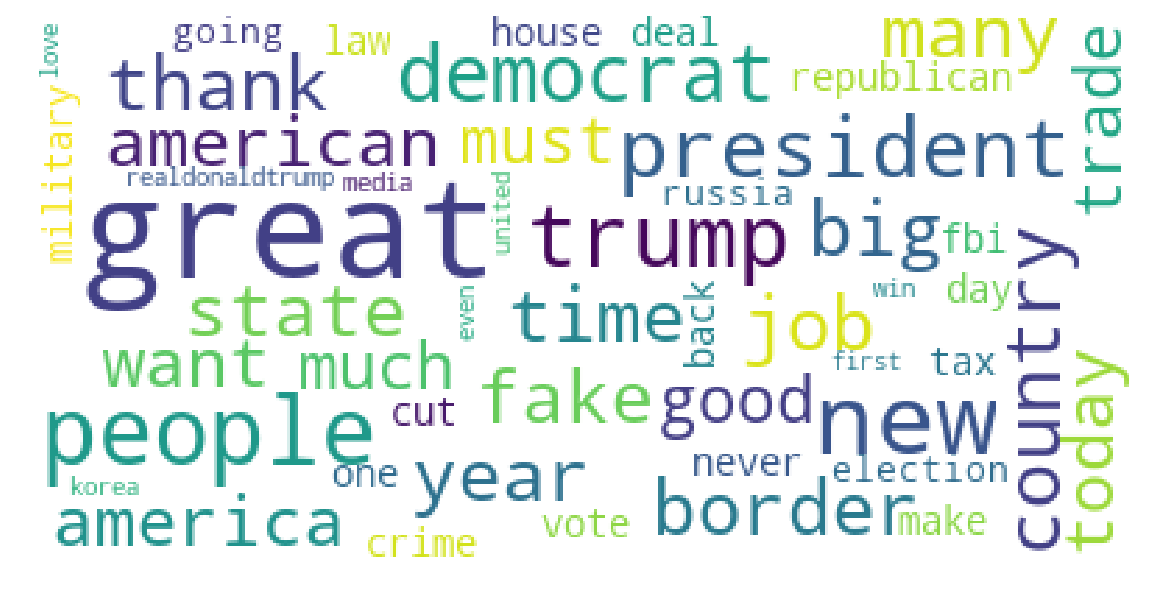

In [37]:
import matplotlib.pyplot as plt
# from PIL import Image
from wordcloud import WordCloud
#generate the word cloud with parameters

print("Here's a wordcloud of all of the text of %s's tweets." % screen_name)
wc = WordCloud(background_color="white", 
               max_words=50, 
               min_font_size =5, 
               max_font_size=50, 
               relative_scaling = 0.6, 
               normalize_plurals= True,
               collocations=False)
fig_sz = (20,20)

wc.generate(' '.join(big_word_list))
plt.figure(figsize=fig_sz)
plt.imshow(wc)
plt.axis("off")

plt.show()


This is a wordcloud of all of the hashtags used in realdonaldtrump's tweets.


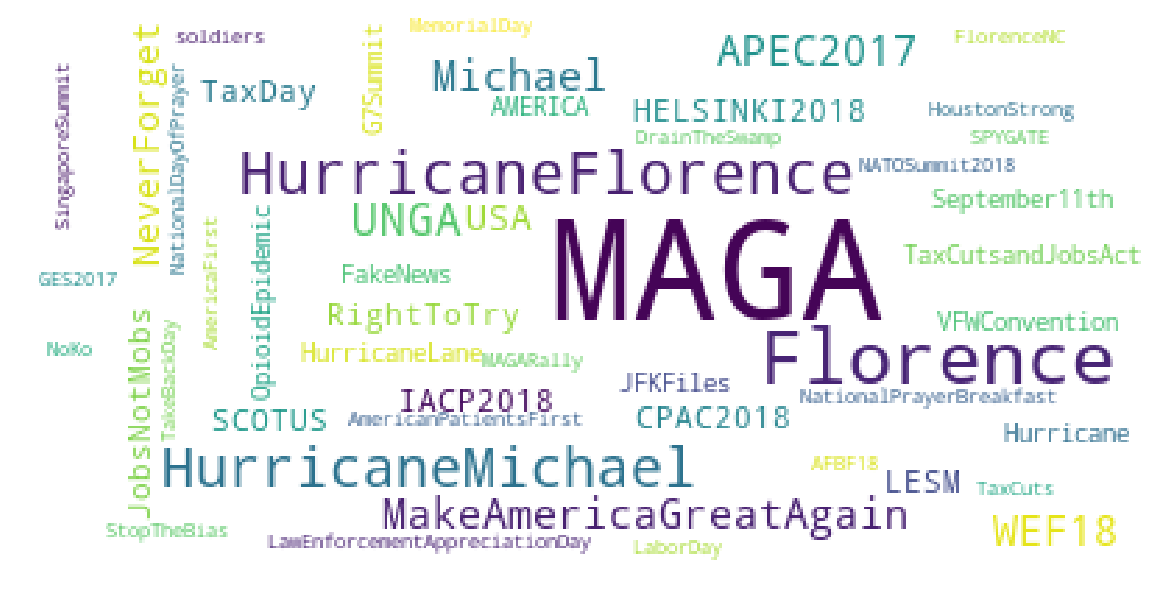

In [38]:
print("This is a wordcloud of all of the hashtags used in %s's tweets." % screen_name)
wc.generate(' '.join(hashtag_list))
plt.figure(figsize=fig_sz)
plt.imshow(wc)
plt.axis("off")

plt.show()

In [39]:
txt = Text(big_word_list)

In [40]:
txt.collocations()

fake news; witch hunt; united states; north korea; tax cuts; white
house; crooked hillary; prime minister; law enforcement; supreme
court; stock market; men women; new york; military vets; hillary
clinton; news media; america great; make america; last night; nancy
pelosi


In [43]:
b_grams = list(bigrams(big_word_list))
bg_count = Counter(b_grams)
print(bg_count.most_common(25))

[(('fake', 'news'), 177), (('witch', 'hunt'), 108), (('united', 'states'), 106), (('north', 'korea'), 93), (('america', 'great'), 84), (('tax', 'cuts'), 79), (('white', 'house'), 69), (('president', 'trump'), 63), (('crooked', 'hillary'), 60), (('great', 'honor'), 58), (('news', 'media'), 58), (('make', 'america'), 57), (('...', '...'), 45), (('new', 'york'), 45), (('military', 'vets'), 44), (('hillary', 'clinton'), 44), (('law', 'enforcement'), 43), (('great', 'state'), 41), (('prime', 'minister'), 40), (('...', '..'), 39), (('supreme', 'court'), 39), (('men', 'women'), 38), (('great', 'job'), 37), (('stock', 'market'), 37), (('total', 'endorsement'), 36)]
